In [ ]:
import torch
import torchmetrics.classification as tc
import torchvision as tv
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torchaudio.transforms as T
from torch.utils.tensorboard import SummaryWriter

from functions.dl.convenience_functions import to_device, trialDir
from functions.dl.data_classes import SpectroDataset, SpectroDataLoader
from functions.dl.data_functions import splitDataset, load_data, load_model, train_model, getBestModel
from functions.dl.network_components import EarlyStopping, AudioToLogSpectrogram

CUDA_LAUNCH_BLOCKING=1
TORCH_USE_CUDA_DSA = 1
%load_ext tensorboard

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
ds = SpectroDataset("./AudioTensors", os.getcwd(), device = 'cuda')

In [4]:
train_indices, test_indices, val_indices  = splitDataset(ds)

In [5]:
batch_size = 8
train_dataloader = SpectroDataLoader(ds, batch_size, samples= train_indices[:1500], device = "cuda")

In [ ]:
val_dataloader = SpectroDataLoader(ds, batch_size, samples= val_indices[:15], device = "cuda")

0
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19068740_audio.flac
1
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19096975_audio.flac
2
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19115260_audio.flac
3
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19126725_audio.flac
4
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19133357_audio.flac
5
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19137487_audio.flac
6
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19139784_audio.flac
7
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19148979_audio.flac
8
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19152848_audio.flac
9
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19162286_audio.flac
10
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19202771_audio.flac
11
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19250699_audio.flac
12
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19754493_audio.flac
13
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\19754487

In [ ]:
test_dataloader = SpectroDataLoader(ds, batch_size, samples= test_indices[:15], device = "cuda")

4373
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21473304_audio.flac
4374
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21502802_audio.flac
4375
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21525865_audio.flac
4376
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21556705_audio.flac
4377
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21568713_audio.flac
4378
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21586206_audio.flac
4379
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21630314_audio.flac
4380
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21689604_audio.flac
4381
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21725964_audio.flac
4382
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21741886_audio.flac
4383
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21761018_audio.flac
4384
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21762672_audio.flac
4385
Getting Z:\Audio_data\Dawn_chorus_conversion_flac\21817477_audio.flac
4386
Getting Z:\Audio_dat

In [6]:
atls = AudioToLogSpectrogram(device = "cuda")

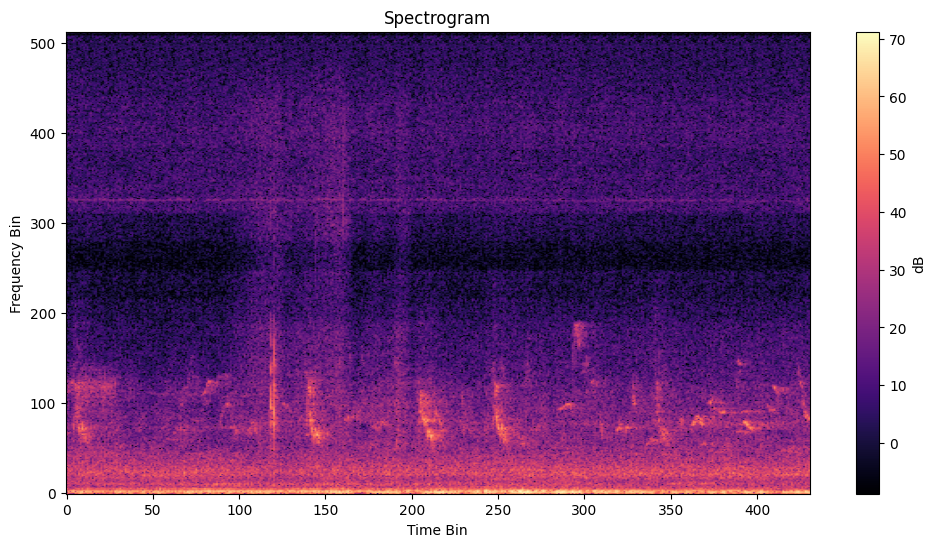

In [7]:
waveform = next(iter(train_dataloader))[0][1]

spectrogram_transform = T.Spectrogram(
    n_fft=1024, 
    hop_length=512, 
    power=2
)

spec = spectrogram_transform(waveform.cpu()) 

spec_db = T.AmplitudeToDB(stype='power', top_db=80)(spec)

plt.figure(figsize=(12, 6))
plt.imshow(
    spec_db.numpy(), 
    origin='lower', 
    aspect='auto', 
    cmap='magma'
)
plt.colorbar(label='dB')
plt.title("Spectrogram")
plt.ylabel("Frequency Bin")
plt.xlabel("Time Bin")
plt.show()

In [8]:
res = tv.models.resnet18()
adaptconv1 = nn.Conv2d (in_channels=1, kernel_size=res.conv1.kernel_size, stride=res.conv1.stride, padding = res.conv1.padding, bias=res.conv1.bias, out_channels=res.conv1.out_channels)
res.conv1 = adaptconv1
res.fc = nn.Linear(in_features=res.fc.in_features, out_features=37, bias=True)

nnw = nn.Sequential(atls, res)

to_device(nnw, device)

Sequential(
  (0): AudioToLogSpectrogram(
    (spec): Spectrogram()
  )
  (1): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchN

In [ ]:
epochs = 40
batch_prints = batch_size
writer = SummaryWriter("runs/single_points")
lr = 0.0001

# Parameters for the ElasticNet penalty
l1_lambda = 0.002
l2_lambda = 0.0015

loss = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=7, delta=0.1, model = nnw)

# fused doesn't work without cuda
if device == 'cuda':
    optimizer = optim.Adam(nnw.parameters(), lr=lr, fused=True)
else:
    optimizer = optim.Adam(nnw.parameters(), lr=lr)

# Train the network
for epoch in range(epochs):  # loop over the dataset multiple times
    nnw.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        outputs = nnw(inputs)

        labels_long = labels.type(torch.LongTensor)
        labels_long = to_device(labels_long.long(), device)
        print(f"Batch Label Min: {labels_long.min()}, Max: {labels_long.max()}")

        los = loss(outputs, labels_long)

        # L1 and L 2Regularization
        for p in nnw.parameters():
            l1_penalty += p.abs().sum()
            l2_penalty += p.pow(2.0).sum()

        # Elastic Net Penalty
        elastic_penalty = l1_lambda * l1_penalty + l2_lambda * l2_penalty

        los += elastic_penalty

        # Clear the gradients
        optimizer.zero_grad()

        # Backpropagation to compute gradients
        los.backward()

        # Update model parameters
        optimizer.step()

        # print statistics
        avg_loss = 0.0
        avg_vloss = 0.0
        l1_penalty = 0
        l2_penalty = 0
        running_loss += los.item()
        print(batch_prints, ": ", i % batch_prints)
        if i % batch_prints == (batch_prints-1):  # print every 16 mini-batches
            
            # Check against validation dataset
            running_vloss = 0.0

            # Switch to evaluation mode to omit some model specific operations like dropout
            nnw.train(False)
            for j, vdata in enumerate(val_dataloader, 0): 
                vinputs, vlabels = vdata
                vlabels_long = to_device(vlabels.type(torch.LongTensor), device)
                voutputs = nnw(vinputs)
                vloss = loss(voutputs, vlabels_long)
                running_vloss  +=vloss.item()
            
            nnw.train(True)
            avg_loss = running_loss / batch_prints

            avg_vloss = running_vloss / len(val_dataloader)

            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(train_dataloader) + i)

            print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.6f} vloss: {avg_vloss:.6f}')

            running_loss = 0.0
        
        
    if early_stopping.check_early_stop(avg_vloss):
        print(f"Stopping training at epoch {epoch+1}")
        break

nnw.eval()
print('Finished Training')

writer.flush()
print("Flushed writer")

nnw.load_state_dict(torch.load(early_stopping.path))

Batch Label Min: 0, Max: 3
8 :  0
Batch Label Min: 0, Max: 3
8 :  1
Batch Label Min: 0, Max: 3
8 :  0
Batch Label Min: 0, Max: 3
8 :  1
Batch Label Min: 0, Max: 3
8 :  0
Batch Label Min: 0, Max: 3
8 :  1
Batch Label Min: 0, Max: 3
8 :  0
Batch Label Min: 0, Max: 3
8 :  1
Batch Label Min: 0, Max: 3
8 :  0
Batch Label Min: 0, Max: 3
8 :  1
Batch Label Min: 0, Max: 3
8 :  0
Batch Label Min: 0, Max: 3
8 :  1
Batch Label Min: 0, Max: 3
8 :  0
Batch Label Min: 0, Max: 3
8 :  1
Batch Label Min: 0, Max: 3
8 :  0
Batch Label Min: 0, Max: 3
8 :  1
Batch Label Min: 0, Max: 3
8 :  0
Batch Label Min: 0, Max: 3
8 :  1
Batch Label Min: 0, Max: 3
8 :  0
Batch Label Min: 0, Max: 3
8 :  1
Batch Label Min: 0, Max: 3
8 :  0
Batch Label Min: 0, Max: 3
8 :  1
Batch Label Min: 0, Max: 3
8 :  0
Batch Label Min: 0, Max: 3
8 :  1
Early stopping triggered.
Stopping training at epoch 12
Finished Training
Flushed writer


<All keys matched successfully>

In [12]:
%tensorboard --logdir runs/single_points/

Reusing TensorBoard on port 6008 (pid 22976), started 6 days, 7:23:14 ago. (Use '!kill 22976' to kill it.)

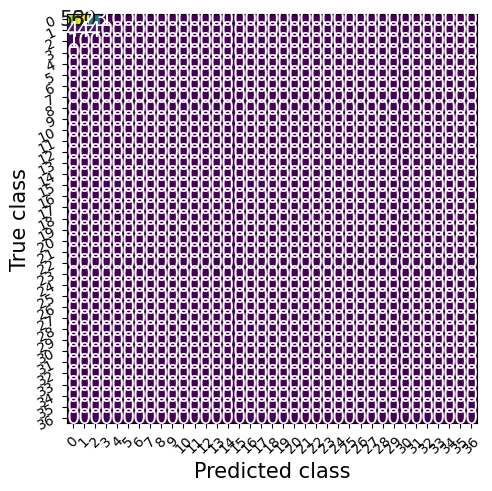

Recall of the custom cnn: tensor(0.1800, device='cuda:0')
F1-score of the custom cnn: tensor(0.1622, device='cuda:0')
Overall accuracy of the custom cnn: tensor(0.1800, device='cuda:0')


In [21]:
preds = torch.Tensor().to(device)
labs = torch.Tensor().to(device)

# Get predictions and corresponding real labels
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        inp = nnw(inputs)

        preds = torch.cat((preds, inp), 0).to(device)
        labs = torch.cat((labs, labels), 0)
        labs = labs.type(torch.LongTensor).to(device)


# Confusion Matrix
metric = tc.MulticlassConfusionMatrix(37).to(device)
metric.update(preds, labs)

fig_, ax_ = metric.plot()
plt.show()


# Compute recall
recall = tc.Recall(task="multiclass", average='macro', num_classes=37).to(device)
recall(preds, labs)
print("Recall of the custom cnn:", recall.compute())

# Compute F1-score
f1 = tc.MulticlassF1Score(37).to(device)
f1(preds, labs)
print("F1-score of the custom cnn:", f1.compute())


# Compute overall accuracy
oa = tc.MulticlassAccuracy(37).to(device)
oa(preds, labs)
print("Overall accuracy of the custom cnn:", oa.compute())